# Accessing google drive

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
%cd /gdrive/My Drive/challenge 2

/gdrive/My Drive/challenge 2


# Importing the required modules

In [3]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import warnings
import logging
import pickle
from sklearn.model_selection import train_test_split
tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


Random seed for reproducibility



In [4]:
seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

#Loading the numpy arrays

### Metadata:
####Time series shape: 2429x36x6
####File format: .npy
####Number of classes: 12
####Classes:
0: "Wish"
1: "Another"
2: "Comfortably"
3: "Money"
4: "Breathe"
5: "Time"
6: "Brain"
7: "Echoes"
8: "Wearing"
9: "Sorrow"
10: "Hey"
11: "Shine"


In [5]:
x = np.load('x_train.npy')
y = np.load('y_train.npy')

In [6]:
x.shape, y.shape

((2429, 36, 6), (2429,))

# Scaling by feature

In [7]:
X = x.reshape(-1,x.shape[-1])
scaler = RobustScaler()
scaler = scaler.fit(X)
X = scaler.transform(X)
x = X.reshape(x.shape)

# Creating a **dataframe**

In [9]:
#Flattening x to get the unique timestamps 
flat = x.reshape(-1,x.shape[-1])
flat.shape

(87444, 6)

In [10]:
#Creating a dataframe of the labels 
df_y = pd.DataFrame(data=y,columns=['label']) 

In [11]:
#Creating dataframe for all the features, and intializing a label column with temporary label of zero
df_x = pd.DataFrame(data=flat,columns=['f1','f2','f3','f4','f5','f6'])
df_x['label'] = 0 

In [12]:
df_x

,f1,f2,f3,f4,f5,f6,label
0,1.894384,1.333320,-0.282070,-1.665811,-0.606524,-2.192279,0
1,-0.005006,-1.083487,1.873873,0.330330,0.063212,1.945614,0
2,-3.273275,-3.729399,3.294017,-0.114479,4.085907,0.292902,0
3,-6.505700,-5.150079,2.005166,-3.755123,0.999377,-1.545807,0
4,-7.911492,-4.512672,-0.021618,-4.847776,-1.675718,-0.480480,0
...,...,...,...,...,...,...,...
87439,0.353951,-0.247950,-0.272206,0.259253,0.080917,0.132502,0
87440,0.047357,-0.233143,-0.297515,0.092826,-0.333815,0.181468,0
87441,-0.007561,0.106164,-0.182607,-0.133944,0.024622,0.090764,0
87442,0.422961,0.117365,-0.097404,0.015884,-0.019427,0.070568,0


In [13]:
#Counting the number of sequences for each class
label_count = df_y.value_counts()
label_count

label
9        777
3        381
6        313
2        270
5        153
1        123
8        120
10        77
7         68
4         62
11        51
0         34
dtype: int64

In [14]:
#Identifying the boundaries of each class sequencesm to help with building the dataframe 
split = []
sum = 0
for i in range(0,12):
  sum = sum + label_count[i]
  split.append(sum)
split

[34, 157, 427, 808, 870, 1023, 1336, 1404, 1524, 2301, 2378, 2429]

In [15]:
#Assigning the right labels for all the sequences
df_x.iloc[:label_count[0]*36]['label'] = 0
for label in range(1,12):
  df_x.iloc[split[label-1]*36:split[label]*36]['label'] = label

<ipython-input-15-d9a297979acf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x.iloc[:label_count[0]*36]['label'] = 0
<ipython-input-15-d9a297979acf>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x.iloc[split[label-1]*36:split[label]*36]['label'] = label


In [16]:
#Checking for the number of classes after converting into a dataframe
df_x['label'].value_counts()/36

9     777.0
3     381.0
6     313.0
2     270.0
5     153.0
1     123.0
8     120.0
10     77.0
7      68.0
4      62.0
11     51.0
0      34.0
Name: label, dtype: float64

In [17]:
df_x

,f1,f2,f3,f4,f5,f6,label
0,1.894384,1.333320,-0.282070,-1.665811,-0.606524,-2.192279,0
1,-0.005006,-1.083487,1.873873,0.330330,0.063212,1.945614,0
2,-3.273275,-3.729399,3.294017,-0.114479,4.085907,0.292902,0
3,-6.505700,-5.150079,2.005166,-3.755123,0.999377,-1.545807,0
4,-7.911492,-4.512672,-0.021618,-4.847776,-1.675718,-0.480480,0
...,...,...,...,...,...,...,...
87439,0.353951,-0.247950,-0.272206,0.259253,0.080917,0.132502,11
87440,0.047357,-0.233143,-0.297515,0.092826,-0.333815,0.181468,11
87441,-0.007561,0.106164,-0.182607,-0.133944,0.024622,0.090764,11
87442,0.422961,0.117365,-0.097404,0.015884,-0.019427,0.070568,11


# Using the sliding window to generate more samples

In [18]:
#A customized function to build sequences by taking the window size and the stride length as arguments 
def build_sequences(df, window=36, stride=36):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    for lab in range(0,12):
        # Take only meaningful features
        temp = df_x[df_x['label'] == lab][['f1','f2','f3','f4','f5','f6']].values
        # Compute padding length
        padding_len = len(temp)%window
        # Create padding and concatenate it
        padding = np.zeros((padding_len,6), dtype='float64')
        temp = np.concatenate((temp,padding))
        # Build features windows with their corresponging labels
        idx = 0
        while idx+window <= len(temp):
            dataset.append(temp[idx:idx+window])
            labels.append(lab)
            idx += stride
    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [19]:
#Creating sequences with the a window size of 36 and a stride of 12
x,y = build_sequences(df_x, window=36, stride=12)

# Splitting the dataset

In [20]:
#One hot encoding to transform the labels into categorical data
y = tfk.utils.to_categorical(y)

In [21]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2)

In [22]:
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((5810, 36, 6), (1453, 36, 6), (5810, 12), (1453, 12))

In [23]:
input_shape = x.shape[1:]
classes = y.shape[-1]
batch_size = 256
epochs = 300
print ('input shape:',input_shape,', classes:', classes)

input shape: (36, 6) , classes: 12


#1D Convolutional Neural Network

In [24]:
def build_1DCNN_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    cnn = tfkl.Conv1D(512,3,padding='same',activation='relu')(input_layer)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(512,3,padding='same',activation='relu')(cnn)
    gap = tfkl.GlobalAveragePooling1D()(cnn)
    dropout = tfkl.Dropout(.5, seed=seed)(gap)

    # Classifier
    classifier = tfkl.Dense(512, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [25]:
model = build_1DCNN_classifier(input_shape, classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 conv1d (Conv1D)             (None, 36, 512)           9728      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 18, 512)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 18, 512)           786944    
                                                                 
 global_average_pooling1d (G  (None, 512)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0     

In [26]:
# Train the model
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(x_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=10, factor=0.5, min_lr=1e-6)
    ]
).history

Epoch 1/300
23/23 [==============================] - 11s 60ms/step - loss: 3.4065 - accuracy: 0.2198 - val_loss: 2.4041 - val_accuracy: 0.2746 - lr: 0.0010
Epoch 2/300
23/23 [==============================] - 0s 15ms/step - loss: 2.4867 - accuracy: 0.3790 - val_loss: 1.9597 - val_accuracy: 0.4501 - lr: 0.0010
Epoch 3/300
23/23 [==============================] - 0s 14ms/step - loss: 2.0574 - accuracy: 0.4349 - val_loss: 1.8115 - val_accuracy: 0.4591 - lr: 0.0010
Epoch 4/300
23/23 [==============================] - 0s 14ms/step - loss: 1.8459 - accuracy: 0.4570 - val_loss: 1.6679 - val_accuracy: 0.4721 - lr: 0.0010
Epoch 5/300
23/23 [==============================] - 0s 14ms/step - loss: 1.6768 - accuracy: 0.4750 - val_loss: 1.5089 - val_accuracy: 0.4886 - lr: 0.0010
Epoch 6/300
23/23 [==============================] - 0s 16ms/step - loss: 1.5745 - accuracy: 0.4976 - val_loss: 1.5339 - val_accuracy: 0.4797 - lr: 0.0010
Epoch 7/300
23/23 [==============================] - 0s 14ms/step - l

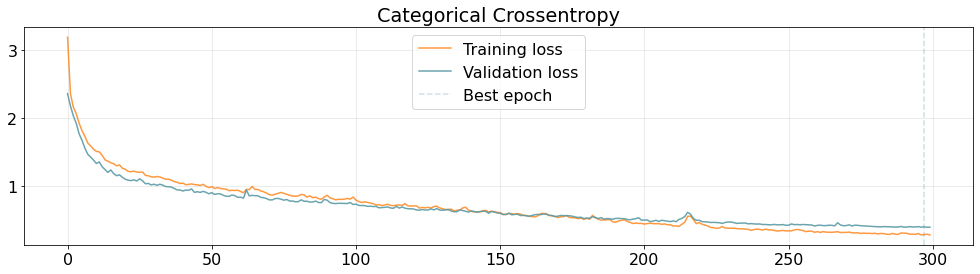

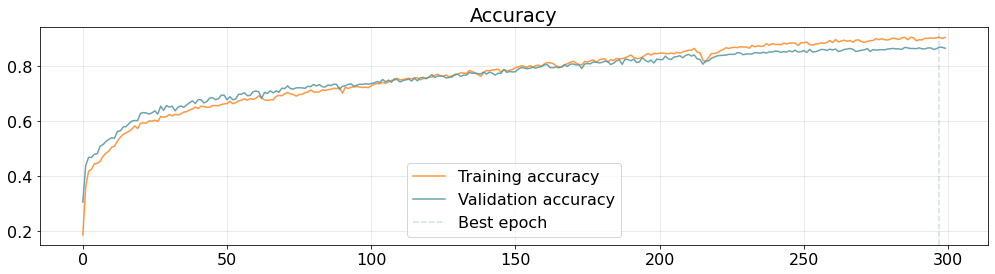

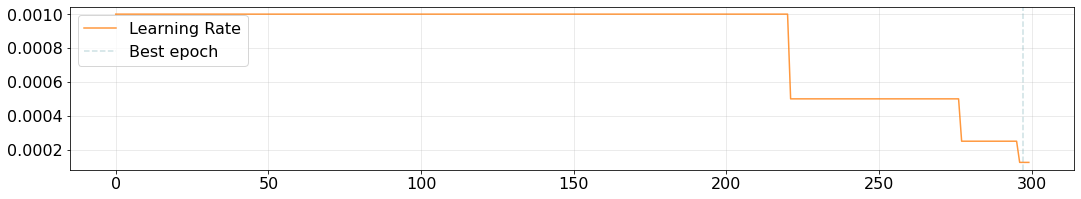

In [ ]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model.save('TCN_Sliding_stride_12_final')